In [16]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import torch
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from sklearn.utils import shuffle
import torchinfo
import torcheval
from torcheval.metrics import BinaryAccuracy
from tqdm import tqdm
import os
from dotenv import load_dotenv
#from keras.datasets import cifar10

height, width = 32, 32
LR = 0.01

#### Setting up MPS for Apple chip.

In [3]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

device

device(type='mps')

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [5]:
load_dotenv()
path_to_image = os.getenv('CIFAR_10_PATH_FILE')

batch_1 = unpickle(path_to_image + 'data_batch_1')
batch_1_data = batch_1['data']
batch_1_labels = batch_1['labels']

batch_2 = unpickle(path_to_image + 'data_batch_2')
batch_2_data = batch_2['data']
batch_2_labels = batch_2['labels']

batch_3 = unpickle(path_to_image + 'data_batch_3')
batch_3_data = batch_3['data']
batch_3_labels = batch_3['labels']

batch_4 = unpickle(path_to_image + 'data_batch_4')
batch_4_data = batch_4['data']
batch_4_labels = batch_4['labels']

batch_5 = unpickle(path_to_image + 'data_batch_5')
batch_5_data = batch_5['data']
batch_5_labels = batch_5['labels']

test_set = unpickle(path_to_image + 'test_batch')

all_batch = np.concatenate((batch_1_data, batch_2_data, batch_3_data, batch_4_data, batch_5_data))
all_labels = np.concatenate((batch_1_labels, batch_2_labels, batch_3_labels, batch_4_labels, batch_5_labels))

data = {'data': all_batch, 'labels': all_labels}

print(batch_1.keys())
print(f"We have {len(batch_1['labels'])} number of data")

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
We have 10000 number of data


Text(0.5, 1.0, '2')

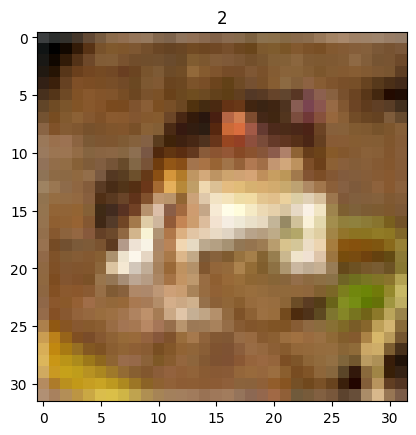

In [6]:
import matplotlib.pyplot as plt
# label names
label_name = batch_1['labels']
# take first image
image = batch_1['data'][0]
# take first image label index
label = batch_1['labels'][0]
# Reshape the image
image = image.reshape(3,32,32)
# Transpose the image
image = image.transpose(1,2,0)
# Display the image
plt.imshow(image)
plt.title(label_name[label])

# Creating a Custom Dataset

In [7]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = tt.Compose([
    tt.ToPILImage(),
    tt.Resize((height, width)),
    tt.TrivialAugmentWide(num_magnitude_bins=31),
    tt.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = tt.Compose([
    tt.ToPILImage(),
    tt.Resize((height, width)),
    tt.ToTensor()
])

In [8]:
class CIFAR10(Dataset):
    def __init__(self, data_dict, transform):
        self.data_dict = data_dict
        self.transform = transform
        
        labels = self.data_dict['labels']
        
    def __len__(self):
        return len(self.data_dict['labels'])
    
    def __getitem__(self, idx):
        
        img = self.data_dict['data'][idx]
        label = self.data_dict['labels'][idx]

        img = torch.tensor(img.reshape(3,height,width), dtype=torch.float)

        if not isinstance(label,np.int64):
            label = torch.tensor(label, dtype=torch.float)
            
        return self.transform(img), label

In [9]:
train_data_custom = CIFAR10(data, transform = train_transform_trivial_augment)
test_data_custom = CIFAR10(test_set, transform = test_transform)

In [10]:
print(f"We have {len(train_data_custom)} training datapoints and {len(test_data_custom)} testing datapoints")

We have 50000 training datapoints and 10000 testing datapoints


# Custom DataLoaders

In [11]:
BATCH_SIZE = 128

train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=BATCH_SIZE, 
                                     # num_workers=1,
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=BATCH_SIZE, 
                                    # num_workers=1, 
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2a396b280>,
 <torch.utils.data.dataloader.DataLoader at 0x2a396bca0>)

#### Checking if our DataLoaders are working as intended.

In [12]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape} -> [batch_size]")

Image shape: torch.Size([128, 3, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([128]) -> [batch_size]


#### Seems like we've got our data in order.
#### Let's proceed on with modeling.

# Modeling

#### Let's first go with a very basic CNN model.

In [17]:
class Basic_CNN(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_shape, 3, 1, 1), # hidden * 32 * 32
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 32 * 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 16 * 16 
                         stride=2)
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 16 * 16 
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 16 * 16 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 8 * 8 
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * 8 * 8, output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_2(self.conv_1(x)))
    
torch.manual_seed(42)
basic_model = Basic_CNN(3,32,10)
basic_model.to(device)

Basic_CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

#### Let's define our loss metric and optimizer.

In [18]:
lf = nn.CrossEntropyLoss() # Adding the sigmoid function as well
optimizer = torch.optim.SGD(params = basic_model.parameters(), lr = LR)

#### Let's create a training and validation routine.

In [19]:
epochs = 100
train_loss_arr = []
test_loss_arr = []
test_accuracy_arr = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
        basic_model.train()
                
        # Forward
        y_pred = basic_model(X)
        
        # Calculate loss
        loss = lf(y_pred,torch.tensor(y, dtype=torch.long))
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    basic_model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):

            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = basic_model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, torch.tensor(y, dtype=torch.long))

            # Calculate test accuracy 
            test_acc += ((int(torch.sum(torch.argmax(test_pred, dim=1) == y))/BATCH_SIZE)*100)
            
            
        test_loss /= len(test_dataloader_custom)
        test_acc /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_accuracy_arr.append(test_acc)

    if epoch % 10 == 0:
        print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

del basic_model

  1%|          | 1/100 [00:09<15:27,  9.37s/it]


Epoch: 0 | Train loss: 2.30262 | Test loss: 2.30226 | Test Accuracy: 9.88%



 11%|█         | 11/100 [01:41<13:46,  9.28s/it]


Epoch: 10 | Train loss: 1.96763 | Test loss: 1.75152 | Test Accuracy: 38.74%



 21%|██        | 21/100 [03:13<12:06,  9.19s/it]


Epoch: 20 | Train loss: 1.76212 | Test loss: 1.47741 | Test Accuracy: 46.40%



 31%|███       | 31/100 [04:45<10:31,  9.16s/it]


Epoch: 30 | Train loss: 1.61378 | Test loss: 1.24446 | Test Accuracy: 55.94%



 41%|████      | 41/100 [06:18<09:13,  9.38s/it]


Epoch: 40 | Train loss: 1.48155 | Test loss: 1.11729 | Test Accuracy: 60.84%



 51%|█████     | 51/100 [07:52<07:41,  9.42s/it]


Epoch: 50 | Train loss: 1.39720 | Test loss: 1.03148 | Test Accuracy: 63.60%



 61%|██████    | 61/100 [09:26<06:04,  9.35s/it]


Epoch: 60 | Train loss: 1.33683 | Test loss: 0.97422 | Test Accuracy: 65.40%



 71%|███████   | 71/100 [11:00<04:31,  9.35s/it]


Epoch: 70 | Train loss: 1.28470 | Test loss: 0.93842 | Test Accuracy: 66.19%



 81%|████████  | 81/100 [12:30<02:50,  8.97s/it]


Epoch: 80 | Train loss: 1.23681 | Test loss: 0.91017 | Test Accuracy: 67.43%



 91%|█████████ | 91/100 [14:01<01:21,  9.08s/it]


Epoch: 90 | Train loss: 1.19013 | Test loss: 0.85618 | Test Accuracy: 69.73%



100%|██████████| 100/100 [15:22<00:00,  9.23s/it]


#### Let's take a look at the process.

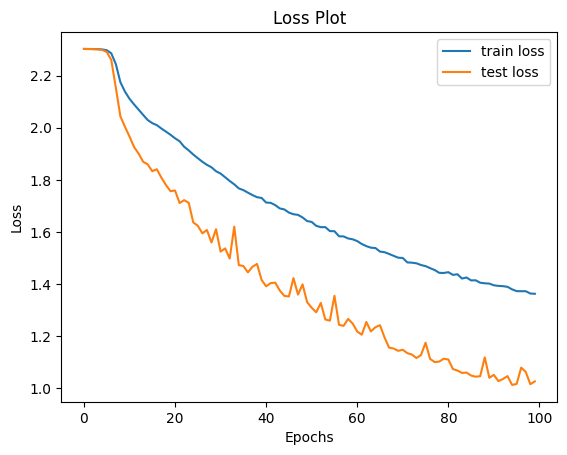

In [ ]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

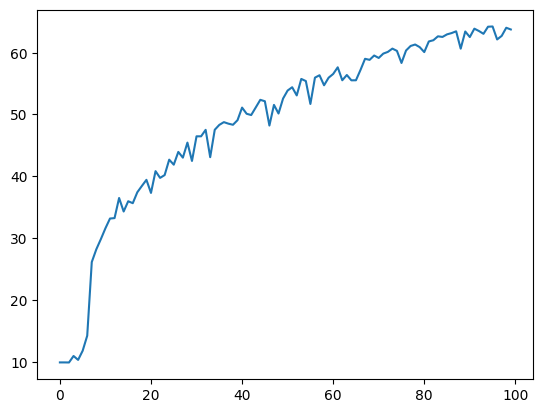

In [ ]:
plt.plot([i for i in range(epochs)], test_accuracy_arr, label='test accuracy')

#### I believe it still has room to run.
#### There are no signs of overfitting as of yet, with the training loss not significantly below the test loss and there are no signs of plateauing so far.
#### Let's move onto a more complex model first.

In [ ]:
class advanced_CNN(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_shape, kernel_size = 7, stride = 1), # hidden_shape * 26 * 26
            nn.BatchNorm2d(hidden_shape),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # hidden_shape * 13 * 13
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, 1, 1), # hidden_shape * 13 * 13
            nn.BatchNorm2d(hidden_shape),
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1), # hidden_shape * 11 * 11
            nn.BatchNorm2d(hidden_shape),
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape*2, 1, 1), # hidden_shape*2 * 11 * 11
            nn.BatchNorm2d(hidden_shape*2)
        )
        self.residual_conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape*2, 3, 1),
            nn.BatchNorm2d(hidden_shape*2)
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(hidden_shape*2, hidden_shape, 1, 1), # hidden_shape * 11 * 11
            nn.BatchNorm2d(hidden_shape),
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1), # hidden_shape * 9 * 9
            nn.BatchNorm2d(hidden_shape),
        )
        self.residual_conv_3 = nn.Sequential(
            
            nn.Conv2d(hidden_shape*2, hidden_shape, 3, 1),
            nn.BatchNorm2d(hidden_shape)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_shape * 9 * 9, output_shape)
        )
        
        self.relu = nn.Sequential(
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out) + self.residual_conv_2(out)
        out = self.relu(out)
        out = self.conv_3(out) + self.residual_conv_3(out)
        out = self.relu(out)
        return self.classifier(out)
    
torch.manual_seed(42)
advanced_model = advanced_CNN(3,12,10)
advanced_model.to(device)

advanced_CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(12, 24, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual_conv_2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3): Sequential

#### Let's try to train this model.

In [ ]:
lf = nn.CrossEntropyLoss() # Adding the sigmoid function as well
optimizer = torch.optim.SGD(params = advanced_model.parameters(), lr = LR)

In [ ]:
epochs = 20
train_loss_arr = []
test_loss_arr = []
test_accuracy_arr = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
        advanced_model.train()
                
        # Forward
        y_pred = advanced_model(X)
        
        # Calculate loss
        loss = lf(y_pred,torch.tensor(y, dtype=torch.long))
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    advanced_model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):

            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = advanced_model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, torch.tensor(y, dtype=torch.long))

            # Calculate test accuracy 
            test_acc += ((int(torch.sum(torch.argmax(test_pred, dim=1) == y))/BATCH_SIZE)*100)
            
            
        test_loss /= len(test_dataloader_custom)
        test_acc /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_accuracy_arr.append(test_acc)

    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

del advanced_model

  5%|▌         | 1/20 [00:11<03:37, 11.44s/it]


Epoch: 0 | Train loss: 2.14870 | Test loss: 1.78951 | Test Accuracy: 35.48%



 10%|█         | 2/20 [00:22<03:22, 11.27s/it]


Epoch: 1 | Train loss: 1.97527 | Test loss: 1.83395 | Test Accuracy: 34.85%



 15%|█▌        | 3/20 [00:33<03:09, 11.17s/it]


Epoch: 2 | Train loss: 1.89631 | Test loss: 1.62458 | Test Accuracy: 42.74%



 20%|██        | 4/20 [00:44<02:57, 11.08s/it]


Epoch: 3 | Train loss: 1.84563 | Test loss: 2.43794 | Test Accuracy: 22.70%



 25%|██▌       | 5/20 [00:55<02:45, 11.01s/it]


Epoch: 4 | Train loss: 1.80016 | Test loss: 1.51547 | Test Accuracy: 44.46%



 30%|███       | 6/20 [01:06<02:32, 10.89s/it]


Epoch: 5 | Train loss: 1.77543 | Test loss: 1.59731 | Test Accuracy: 42.50%



 35%|███▌      | 7/20 [01:16<02:20, 10.83s/it]


Epoch: 6 | Train loss: 1.75139 | Test loss: 2.03570 | Test Accuracy: 30.28%



 40%|████      | 8/20 [01:27<02:09, 10.78s/it]


Epoch: 7 | Train loss: 1.73311 | Test loss: 1.90585 | Test Accuracy: 32.81%



 45%|████▌     | 9/20 [01:38<01:58, 10.75s/it]


Epoch: 8 | Train loss: 1.71892 | Test loss: 1.63143 | Test Accuracy: 40.75%



 50%|█████     | 10/20 [01:48<01:47, 10.74s/it]


Epoch: 9 | Train loss: 1.69943 | Test loss: 1.44288 | Test Accuracy: 47.41%



 55%|█████▌    | 11/20 [01:59<01:36, 10.71s/it]


Epoch: 10 | Train loss: 1.68716 | Test loss: 1.79756 | Test Accuracy: 37.03%



 60%|██████    | 12/20 [02:10<01:25, 10.69s/it]


Epoch: 11 | Train loss: 1.67639 | Test loss: 1.39572 | Test Accuracy: 50.39%



 65%|██████▌   | 13/20 [02:20<01:14, 10.68s/it]


Epoch: 12 | Train loss: 1.66457 | Test loss: 1.92694 | Test Accuracy: 38.59%



 70%|███████   | 14/20 [02:31<01:03, 10.66s/it]


Epoch: 13 | Train loss: 1.64804 | Test loss: 1.44411 | Test Accuracy: 46.48%



 75%|███████▌  | 15/20 [02:42<00:53, 10.65s/it]


Epoch: 14 | Train loss: 1.63471 | Test loss: 1.50375 | Test Accuracy: 44.55%



 80%|████████  | 16/20 [02:52<00:42, 10.63s/it]


Epoch: 15 | Train loss: 1.62565 | Test loss: 1.50064 | Test Accuracy: 44.92%



 85%|████████▌ | 17/20 [03:03<00:31, 10.62s/it]


Epoch: 16 | Train loss: 1.61473 | Test loss: 1.48349 | Test Accuracy: 47.71%



 90%|█████████ | 18/20 [03:13<00:21, 10.61s/it]


Epoch: 17 | Train loss: 1.59637 | Test loss: 1.27255 | Test Accuracy: 54.98%



 95%|█████████▌| 19/20 [03:24<00:10, 10.62s/it]


Epoch: 18 | Train loss: 1.59779 | Test loss: 1.36753 | Test Accuracy: 51.24%



100%|██████████| 20/20 [03:35<00:00, 10.75s/it]


Epoch: 19 | Train loss: 1.58981 | Test loss: 1.58472 | Test Accuracy: 42.59%



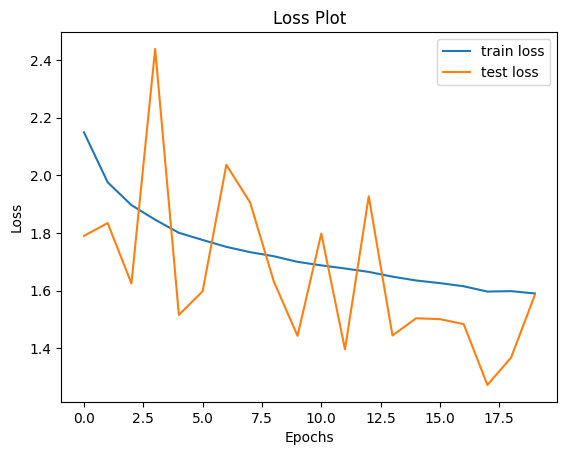

In [ ]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

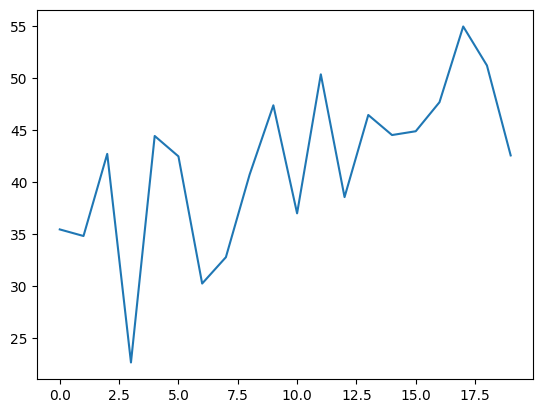

In [ ]:
plt.plot([i for i in range(epochs)], test_accuracy_arr, label='test accuracy')

#### With a more complex model, it seems like the results were all over the place but still showed better numerical value. 
#### It showed certain signs of overfitting too.
#### It could be that the model contained too much features and that led to overfitting unnecessarily.
#### Or it could be that there was a lack of data for the amount of complexity in the feature.

# Study of batch sizes and its effect on model's performance.

#### The study for the effect of batch sizes and the possibility of an optimal numerical figure has been a question I have had for a while and I wish to explore with this project.
#### For a smoother result, I will be using the former, simpler model and varying the batch size to see what results it shows.

In [ ]:
from collections import defaultdict

batch_sizes_experiment = [32, 64, 128, 256, 512, 1024]
diff_batch_score_dict = defaultdict(list)

for size in batch_sizes_experiment:

    print(f"Testing for size {size}")
    
    BATCH_SIZE = size
    train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1,
                                        shuffle=True) 

    test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1, 
                                        shuffle=False) 

    torch.manual_seed(42)
    basic_model = Basic_CNN(3,32,10)
    basic_model.to(device)

    lf = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(params = basic_model.parameters(), lr = LR)

    epochs = 100
    train_loss_arr = []
    test_loss_arr = []
    test_accuracy_arr = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0
        
        for batch, (X,y) in enumerate(train_dataloader_custom):
            X = X.to(device)
            y = y.to(device)
            basic_model.train()
                    
            # Forward
            y_pred = basic_model(X)
            
            # Calculate loss
            loss = lf(y_pred,torch.tensor(y, dtype=torch.long))
            train_loss += loss
            
            # Zero grad
            optimizer.zero_grad()
            
            # Loss backward
            loss.backward()
            
            # Optimizer step
            optimizer.step()
        
        train_loss/=len(train_dataloader_custom)
        train_loss_arr.append(train_loss.cpu().detach().numpy())
        
        test_loss, test_acc= 0, 0
        basic_model.eval() 
        with torch.inference_mode():
            for batch, (X,y) in enumerate(test_dataloader_custom):

                X = X.to(device)
                y = y.to(device)
                
                # Forward
                test_pred = basic_model(X)
                
                # Calculate loss 
                test_loss += lf(test_pred, torch.tensor(y, dtype=torch.long))

                # Calculate test accuracy 
                test_acc += ((int(torch.sum(torch.argmax(test_pred, dim=1) == y))/BATCH_SIZE)*100)
                
                
            test_loss /= len(test_dataloader_custom)
            test_acc /= len(test_dataloader_custom)
            test_loss_arr.append(test_loss.cpu().detach().numpy())
            diff_batch_score_dict[f"{size}"].append(test_loss.cpu().detach().numpy())
            test_accuracy_arr.append(test_acc)

    del basic_model

Testing for size 32


100%|██████████| 100/100 [25:36<00:00, 15.37s/it]


Testing for size 64


100%|██████████| 100/100 [21:16<00:00, 12.76s/it]


Testing for size 128


100%|██████████| 100/100 [19:51<00:00, 11.91s/it]


Testing for size 256


100%|██████████| 100/100 [19:30<00:00, 11.70s/it]


Testing for size 512


100%|██████████| 100/100 [19:25<00:00, 11.66s/it]


Testing for size 1024


100%|██████████| 100/100 [19:30<00:00, 11.70s/it]


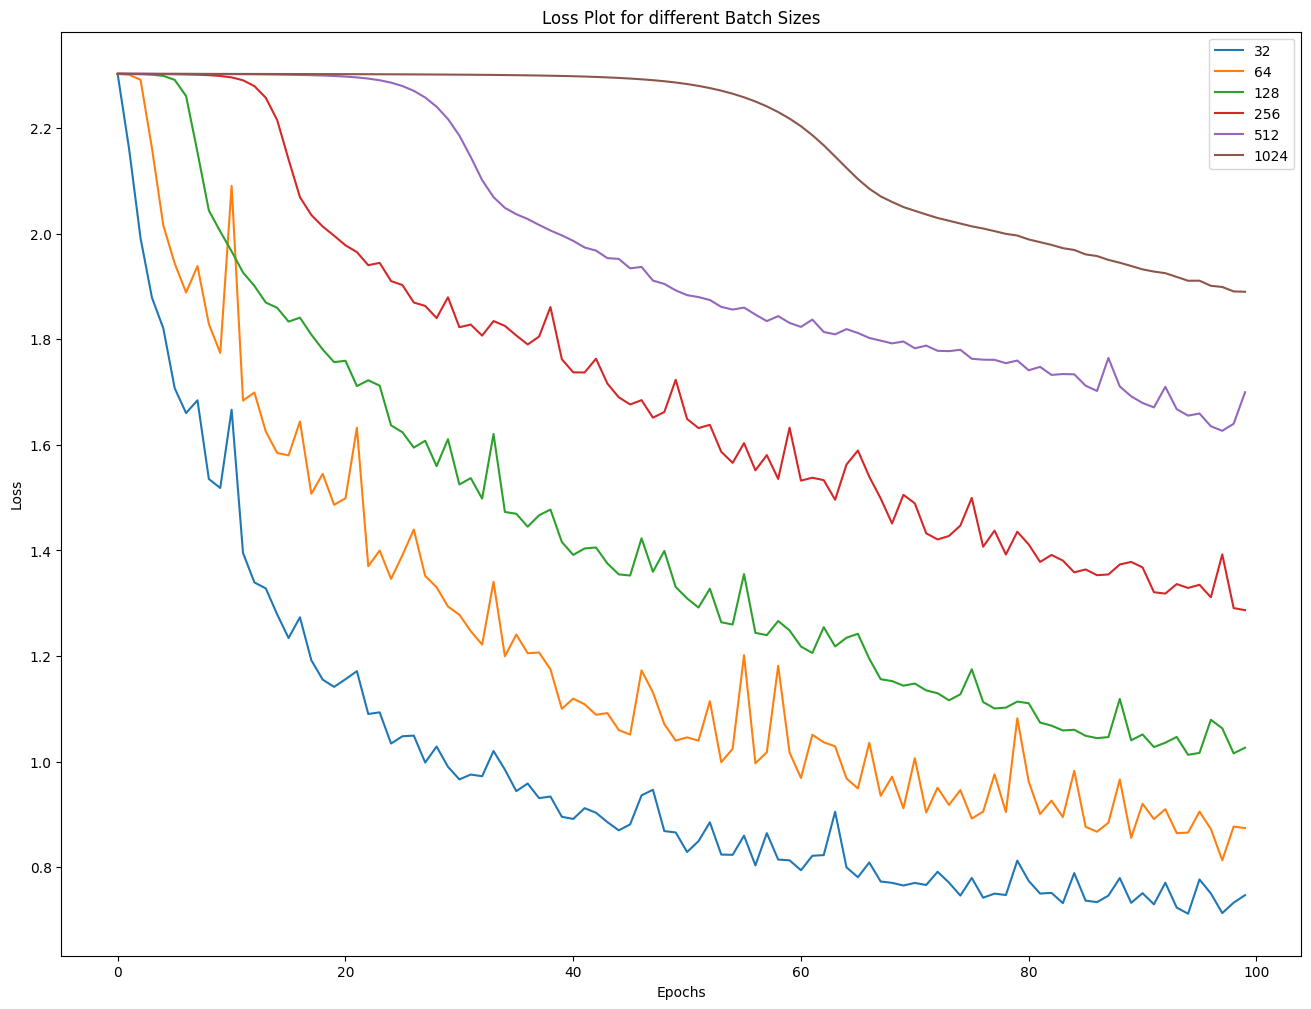

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot([i for i in range(epochs)], diff_batch_score_dict['32'], label='32')
plt.plot([i for i in range(epochs)], diff_batch_score_dict['64'], label='64')
plt.plot([i for i in range(epochs)], diff_batch_score_dict['128'], label='128')
plt.plot([i for i in range(epochs)], diff_batch_score_dict['256'], label='256')
plt.plot([i for i in range(epochs)], diff_batch_score_dict['512'], label='512')
plt.plot([i for i in range(epochs)], diff_batch_score_dict['1024'], label='1024')
plt.title('Loss Plot for different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### It seems that with a bigger batch size, the model takes longer to learn, judging from the observation that it has a smaller gradient. 
#### However, a benefit with bigger batch sizes could be a shorter training time as can be observed by the time taken to train 100 epochs and I believe there is also smaller volatility associated with larger batch sizes.
#### Let's try to prove our hypothesis through mathematics. 
#### We can calculate the standard deviation of these plots and observe the mean standard deviation value.

In [ ]:
std_32 = np.std(diff_batch_score_dict['32'])
std_64 = np.std(diff_batch_score_dict['64'])
std_128 = np.std(diff_batch_score_dict['128'])
std_256 = np.std(diff_batch_score_dict['256'])
std_512 = np.std(diff_batch_score_dict['512'])
std_1024 = np.std(diff_batch_score_dict['1024'])

std_dict = {}
std_dict['32'] = [std_32]
std_dict['64'] = [std_64]
std_dict['128'] = [std_128]
std_dict['256'] = [std_256]
std_dict['512'] = [std_512]
std_dict['1024'] = [std_1024]

std_df = pd.DataFrame(std_dict)

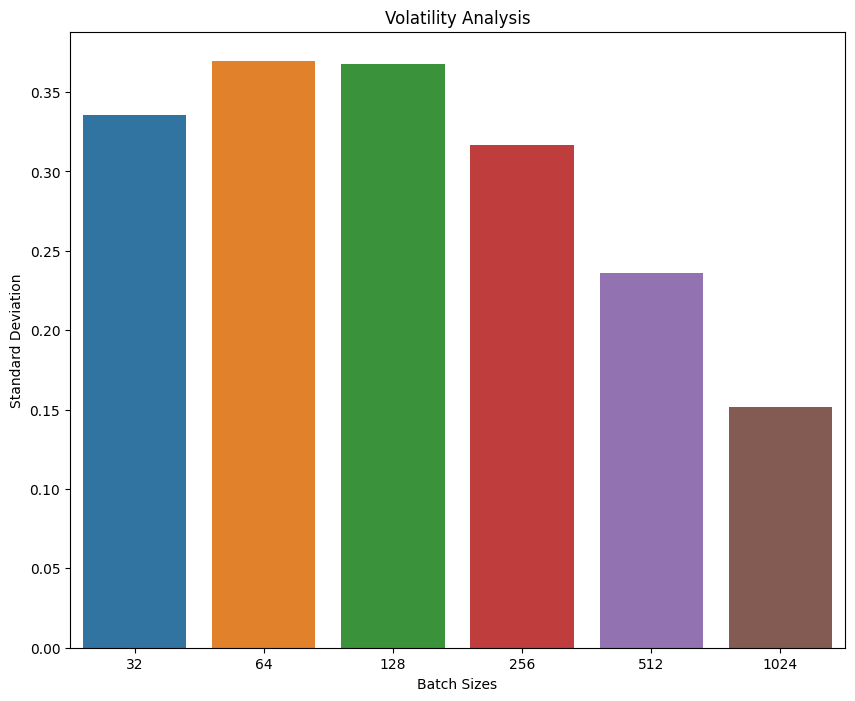

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,8))
ax = sns.barplot(std_df).set(title='Volatility Analysis')
plt.xlabel("Batch Sizes")
plt.ylabel("Standard Deviation")
plt.show()


#### The volatility doesn't seem to be a linear trend that I have expected. 
#### The standard deviation peaks at batch size of 128 and goes lower beyond it and prior to it. 

#### With this result, I believe we can pick out the most optimal batch size in this case, which would be 32. 
#### Although it has a higher standard deviation value and takes longer to run 100 epochs than the 1024 batch size, it reaches a lower loss value the quickest. 
#### I believe the experiement to conduct now is to run the model with 32 batch size and with 100 epochs. 
#### The second experiment would be to run the model with 1024 batch size but with 500 epochs. 
#### After which we can compare the results. 

# 32 vs 1024 batch sizes

#### Let's run with a 32 batch size.

In [ ]:
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1,
                                        shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1, 
                                        shuffle=False) 

torch.manual_seed(42)
basic_model = Basic_CNN(3,32,10)
basic_model.to(device)

lf = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params = basic_model.parameters(), lr = LR)

epochs = 100
train_loss_arr = []
test_loss_arr = []
test_accuracy_arr = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
        
    for batch, (X,y) in enumerate(train_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
        basic_model.train()
                    
        # Forward
        y_pred = basic_model(X)
            
        # Calculate loss
        loss = lf(y_pred,torch.tensor(y, dtype=torch.long))
        train_loss += loss
            
        # Zero grad
        optimizer.zero_grad()
            
        # Loss backward
        loss.backward()
            
        # Optimizer step
        optimizer.step()
        
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
        
    test_loss, test_acc= 0, 0
    basic_model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):

            X = X.to(device)
            y = y.to(device)
                
            # Forward
            test_pred = basic_model(X)
                
            # Calculate loss 
            test_loss += lf(test_pred, torch.tensor(y, dtype=torch.long))

            # Calculate test accuracy 
            test_acc += ((int(torch.sum(torch.argmax(test_pred, dim=1) == y))/BATCH_SIZE)*100)
                
                
        test_loss /= len(test_dataloader_custom)
        test_acc /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_accuracy_arr.append(test_acc)

del basic_model

 21%|██        | 21/100 [06:16<23:37, 17.94s/it]


KeyboardInterrupt: 

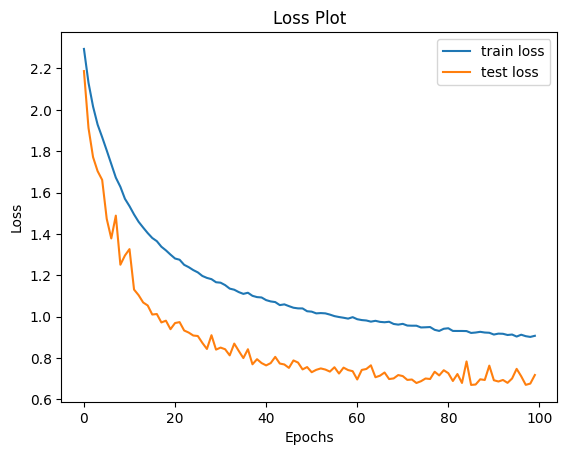

In [ ]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### Let's run with a 1024 batch sizes now.

In [ ]:
BATCH_SIZE = 1024
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1,
                                        shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1, 
                                        shuffle=False) 

torch.manual_seed(42)
basic_model = Basic_CNN(3,32,10)
basic_model.to(device)

lf = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params = basic_model.parameters(), lr = LR)

epochs = 500
train_loss_arr = []
test_loss_arr = []
test_accuracy_arr = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
        
    for batch, (X,y) in enumerate(train_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
        basic_model.train()
                    
        # Forward
        y_pred = basic_model(X)
            
        # Calculate loss
        loss = lf(y_pred,torch.tensor(y, dtype=torch.long))
        train_loss += loss
            
        # Zero grad
        optimizer.zero_grad()
            
        # Loss backward
        loss.backward()
            
        # Optimizer step
        optimizer.step()
        
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
        
    test_loss, test_acc= 0, 0
    basic_model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):

            X = X.to(device)
            y = y.to(device)
                
            # Forward
            test_pred = basic_model(X)
                
            # Calculate loss 
            test_loss += lf(test_pred, torch.tensor(y, dtype=torch.long))

            # Calculate test accuracy 
            test_acc += ((int(torch.sum(torch.argmax(test_pred, dim=1) == y))/BATCH_SIZE)*100)
                
                
        test_loss /= len(test_dataloader_custom)
        test_acc /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_accuracy_arr.append(test_acc)

del basic_model

100%|██████████| 500/500 [2:05:45<00:00, 15.09s/it]    


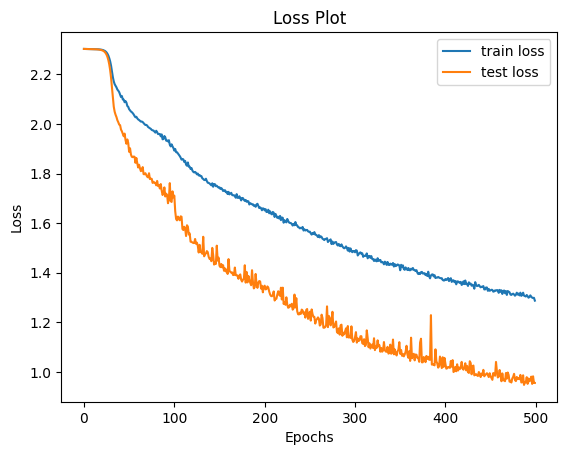

In [ ]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### With a larger batch size, it definitely seems to take longer to find the optimal point. 
#### According to the article [here](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e), using a large batch size will have a higher probability of converging to the global optima of the objective function.
#### However, it also mentioned that it is at the cost of slower convergence, which is very evident from our plot here. 
#### Even with 500 epochs, it doesn't seem to outperform the prior experiment with 32 batch size yet. 
#### It seems to require training over more epochs. 

#### But this got me thinking, whether training with a larger batch size would be more helpful for the advanced model. 
#### As we saw, the metric value for the advanced model was all over the place and didn't show a steady improvement although it tended to lower in the loss metric quicker. 
#### Let's test out a larger batch size on the advanced model this time.

# Larger Batch size for advanced model

In [ ]:
BATCH_SIZE = 1024
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1,
                                        shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                        batch_size=BATCH_SIZE, 
                                        # num_workers=1, 
                                        shuffle=False) 

torch.manual_seed(42)
advanced_model = advanced_CNN(3,32,10)
advanced_model.to(device)

lf = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params = advanced_model.parameters(), lr = 0.001)

epochs = 500
train_loss_arr = []
test_loss_arr = []
test_accuracy_arr = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
        
    for batch, (X,y) in enumerate(train_dataloader_custom):
        X = X.to(device)
        y = y.to(device)
        advanced_model.train()
                    
        # Forward
        y_pred = advanced_model(X)
            
        # Calculate loss
        loss = lf(y_pred,torch.tensor(y, dtype=torch.long))
        train_loss += loss
            
        # Zero grad
        optimizer.zero_grad()
            
        # Loss backward
        loss.backward()
            
        # Optimizer step
        optimizer.step()
        
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
        
    test_loss, test_acc= 0, 0
    advanced_model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):

            X = X.to(device)
            y = y.to(device)
                
            # Forward
            test_pred = advanced_model(X)
                
            # Calculate loss 
            test_loss += lf(test_pred, torch.tensor(y, dtype=torch.long))

            # Calculate test accuracy 
            test_acc += ((int(torch.sum(torch.argmax(test_pred, dim=1) == y))/BATCH_SIZE)*100)
                
                
        test_loss /= len(test_dataloader_custom)
        test_acc /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_accuracy_arr.append(test_acc)

    if epoch % 10 == 0:
        print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

del advanced_model

  0%|          | 1/500 [00:08<1:07:17,  8.09s/it]


Epoch: 0 | Train loss: 2.49521 | Test loss: 2.31294 | Test Accuracy: 12.05%



  2%|▏         | 11/500 [01:29<1:07:52,  8.33s/it]


Epoch: 10 | Train loss: 2.09775 | Test loss: 1.83622 | Test Accuracy: 33.54%



  4%|▍         | 21/500 [02:56<1:09:28,  8.70s/it]


Epoch: 20 | Train loss: 1.97995 | Test loss: 1.68140 | Test Accuracy: 39.46%



  6%|▌         | 31/500 [04:36<1:24:58, 10.87s/it]


Epoch: 30 | Train loss: 1.90272 | Test loss: 1.59678 | Test Accuracy: 42.10%



  8%|▊         | 41/500 [06:29<1:24:43, 11.07s/it]


Epoch: 40 | Train loss: 1.85302 | Test loss: 1.53322 | Test Accuracy: 44.52%



 10%|█         | 51/500 [08:22<1:22:06, 10.97s/it]


Epoch: 50 | Train loss: 1.80871 | Test loss: 1.48333 | Test Accuracy: 46.53%



 12%|█▏        | 61/500 [10:10<1:19:42, 10.89s/it]


Epoch: 60 | Train loss: 1.77157 | Test loss: 1.43755 | Test Accuracy: 47.90%



 14%|█▍        | 71/500 [11:59<1:17:51, 10.89s/it]


Epoch: 70 | Train loss: 1.73408 | Test loss: 1.39694 | Test Accuracy: 49.69%



 16%|█▌        | 81/500 [13:49<1:17:06, 11.04s/it]


Epoch: 80 | Train loss: 1.70910 | Test loss: 1.36223 | Test Accuracy: 50.44%



 18%|█▊        | 91/500 [15:41<1:16:56, 11.29s/it]


Epoch: 90 | Train loss: 1.68039 | Test loss: 1.38439 | Test Accuracy: 49.16%



 20%|██        | 101/500 [17:33<1:14:08, 11.15s/it]


Epoch: 100 | Train loss: 1.64739 | Test loss: 1.33292 | Test Accuracy: 51.35%



 22%|██▏       | 111/500 [19:24<1:12:13, 11.14s/it]


Epoch: 110 | Train loss: 1.63118 | Test loss: 1.29684 | Test Accuracy: 52.67%



 24%|██▍       | 121/500 [21:19<1:13:18, 11.61s/it]


Epoch: 120 | Train loss: 1.61197 | Test loss: 1.31691 | Test Accuracy: 52.05%



 26%|██▌       | 131/500 [23:18<1:13:42, 11.99s/it]


Epoch: 130 | Train loss: 1.59686 | Test loss: 1.24580 | Test Accuracy: 54.54%



 28%|██▊       | 141/500 [25:18<1:11:34, 11.96s/it]


Epoch: 140 | Train loss: 1.57040 | Test loss: 1.22305 | Test Accuracy: 55.02%



 30%|███       | 151/500 [27:17<1:08:59, 11.86s/it]


Epoch: 150 | Train loss: 1.55686 | Test loss: 1.20452 | Test Accuracy: 55.96%



 32%|███▏      | 161/500 [29:16<1:05:55, 11.67s/it]


Epoch: 160 | Train loss: 1.53684 | Test loss: 1.20331 | Test Accuracy: 55.80%



 34%|███▍      | 171/500 [31:11<1:02:55, 11.47s/it]


Epoch: 170 | Train loss: 1.53466 | Test loss: 1.20859 | Test Accuracy: 55.39%



 36%|███▌      | 181/500 [33:07<1:01:08, 11.50s/it]


Epoch: 180 | Train loss: 1.51061 | Test loss: 1.16217 | Test Accuracy: 57.43%



 37%|███▋      | 184/500 [33:43<1:02:05, 11.79s/it]

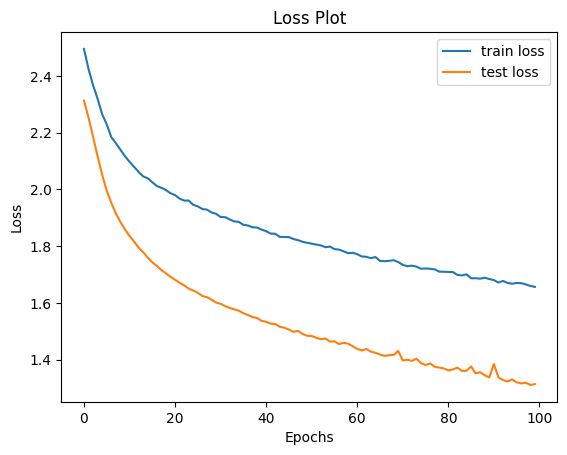

In [ ]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

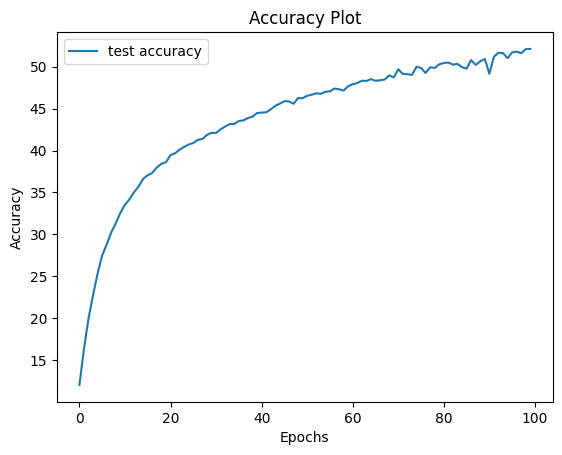

In [ ]:
plt.plot([i for i in range(epochs)], test_accuracy_arr, label='test accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Even with a higher batch size, it still seems to be all over the place and possibly overfitting at each training epoch. 
#### It doesn't seem to be able to ignore noise in the data and generalize.
#### As we can see, the training loss is steadily decreasing but the test loss fails to steadily decrease but jumps around too much.
#### With this advanced model, I believe we might need to take a different approach 
* Collect more data, or artifically generate different ones
* Decrease model's complexity 
* Add regularization to the model 
* Lower learning rate

#### The idea of the optimal batch size seems to be a pull and push problem. 
#### We have to account for various factors such as training time, how well it generalizes to the data and the accuracy of the predictions of the model.

# Credits

* https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
* https://arxiv.org/pdf/1711.00489.pdf